# VAE Practical: Inelastic Neutron Scattering

In [04_CNN_practical.ipynb](04_CNN_practical.ipynb), we have used the inelastic neutron scattering (INS) dataset to practice classification with a convolutional neural network (CNN). In this notebook, we try to make a disentangled variational autoencoder ($\beta$-VAE) to generate new images from the INS dataset, using CNNs for encoding and decoding. 

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import h5py
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Using TensorFlow v2.3.0


## Google Cloud Storage Boilerplate

The following two cells have some boilerplate to mount the Google Cloud Storage bucket containing the data used for this notebook to your Google Colab file system. To access the data, you need to:

1. Run the first cell;
2. Follow the link when prompted (you may be asked to log in with your Google account);
3. Copy the Google SDK token back into the prompt and press `Enter`;
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will take no effect.

In [2]:
# variables passed to bash; do not change
project_id = 'sciml-workshop'
bucket_name = 'sciml-workshop'
colab_data_path = '/content/sciml-workshop-data'

try:
    from google.colab import auth
    auth.authenticate_user()
    google_colab_env = 'true'
    data_path = colab_data_path
except:
    google_colab_env = 'false'
    ###################################################
    ######## specify your local data path here ########
    ###################################################
    data_path = './sciml-workshop-data'

In [3]:
%%bash -s {google_colab_env} {colab_data_path} {project_id} {bucket_name}

# running locally
if ! $1; then
    echo "Running notebook locally."
    exit
fi

# already mounted
if [ -d $2 ]; then
    echo "Data already mounted."
    exit
fi

# mount the bucket
echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
apt -qq update
apt -qq install gcsfuse
gcloud config set project $3
mkdir $2
gcsfuse --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $4 $2

Running notebook locally.


---

# The dataset

The training data are saved in `ins/train.h5`, which contains 20,000 INS images and their one-hot encoded labels identifying an image as either being of the *Dimer* or *Goodenough* Hamiltonian. Similar to [04_CNN_practical.ipynb](04_CNN_practical.ipynb), we first open the dataset using the `tf.data.Dataset` class:

In [4]:
# define image size
IMG_HEIGHT = 20
IMG_WIDTH = 200
N_CHANNELS = 1
N_CLASSES = 2

# generator
def hdf5_generator(path, buffer_size=32):
    """ Load data INS data from disk
    
    Args:
        path: path of the HDF5 file on disk
        buffer_size: number of images to read from disk
    """
    with h5py.File(path, 'r') as handle:
        n_samples, h, w, c = handle['images'].shape
        for i in range(0, n_samples, buffer_size):
            images = handle['images'][i:i+buffer_size, ..., :1]
            labels = handle['labels'][i:i+buffer_size]
            yield images, labels

# training data
train_dataset = tf.data.Dataset.from_generator(lambda: hdf5_generator(path=data_path + '/ins/train.h5'), 
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=((None, IMG_HEIGHT, IMG_WIDTH, N_CHANNELS), 
                                                              (None, N_CLASSES,)))
# print
print(train_dataset)

<FlatMapDataset shapes: ((None, 20, 200, 1), (None, 2)), types: (tf.float32, tf.float32)>


For training a VAE, we need the images for both input and output. Therefore, we use the `map()` method to change the data from `(X, Y)` to `(X, X)`, where `X` represents the images and `Y` the labels.

In [5]:
train_image_dataset = train_dataset.map(lambda X, Y: (X, X))
print(train_image_dataset)

<MapDataset shapes: ((None, 20, 200, 1), (None, 20, 200, 1)), types: (tf.float32, tf.float32)>


In the following cell, we will load the first buffer (with 32 data by default) to memory and plot some images and labels from it:

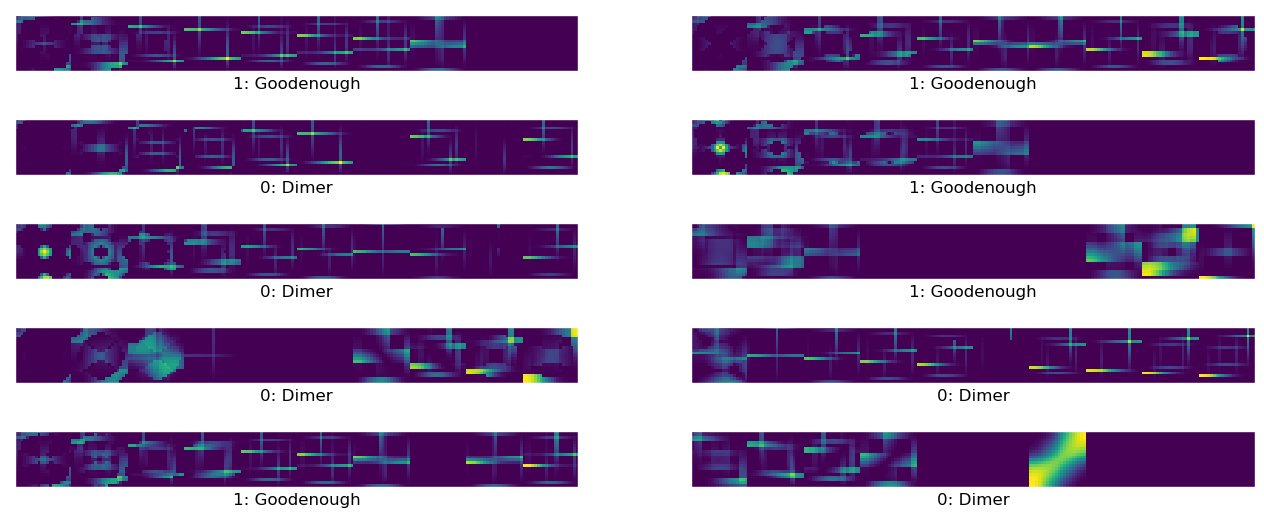

In [6]:
# load the first buffer (with 32 data by default)
images, labels = list(train_dataset.take(1))[0]

# plot some images and labels from it
nplot = 10
fig, axes = plt.subplots(nplot // 2, 2, figsize=(16, nplot / 1.5), dpi=100)
for ax, image, label in zip(axes.flatten(), images, labels):
    ax.matshow(np.squeeze(image))
    ax.set_xlabel('0: Dimer' if label[0] < .5 else '1: Goodenough', c='k')
    ax.set_xticks([])
    ax.set_yticks([])

---

# $\beta$-VAE for  Image Generation

This $\beta$-VAE will be a combination of the CNN architecture in [04_CNN_practical.ipynb](04_CNN_practical.ipynb) and the $\beta$-VAE implementation in [06_VAE_basics.ipynb](06_VAE_basics.ipynb).


## 1. Encoder and decoder

First, we need to specify the latent dimension:

In [7]:
# latent dimension
latent_dim = 16

Now, extend the CNN in [04_CNN_practical.ipynb](04_CNN_practical.ipynb) to an encoder and a decoder. 

**Suggested Answer for Encoder** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# sampling z with (z_mean, z_log_var)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# build the encoder
image_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
x = layers.Conv2D(8, kernel_size=(5, 5), activation='relu', padding='same')(image_input)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_BVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_BVAE.summary()
```
    
</p>
</details>


**Suggested Answer for Decoder** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the decoder
z_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(800, activation="relu")(z_input)
x = layers.Reshape((2, 25, 16))(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.ZeroPadding2D((1, 0))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(8, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
image_output = layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='linear', padding='same')(x)
decoder_BVAE = keras.Model(z_input, image_output)
decoder_BVAE.summary()
```
    
</p>
</details>

In [8]:
# sampling z with (z_mean, z_log_var)
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# build the encoder
image_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, N_CHANNELS))
x = layers.Conv2D(8, kernel_size=(5, 5), activation='relu', padding='same')(image_input)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_output = Sampling()([z_mean, z_log_var])
encoder_BVAE = keras.Model(image_input, [z_mean, z_log_var, z_output])
encoder_BVAE.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 200, 8)   208         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 10, 100, 8)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 10, 100, 8)   32          max_pooling2d[0][0]              
_______________________________________________________________________________________

In [9]:
# build the decoder
z_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(800, activation="relu")(z_input)
x = layers.Reshape((2, 25, 16))(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.ZeroPadding2D((1, 0))(x)
x = layers.Conv2DTranspose(16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(8, kernel_size=(5, 5), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
image_output = layers.Conv2DTranspose(1, kernel_size=(3, 3), activation='linear', padding='same')(x)
decoder_BVAE = keras.Model(z_input, image_output)
decoder_BVAE.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 800)               13600     
_________________________________________________________________
reshape (Reshape)            (None, 2, 25, 16)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 50, 16)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 50, 16)         2320      
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 50, 16)         64        
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 100, 16)       

## 2. The `BVAE` class

The `BVAE` class will be exactly the same as implemented in [06_VAE_basics.ipynb](06_VAE_basics.ipynb).

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# BVAE class
class BVAE(keras.Model):
    # constructor
    ########################################################
    ######## NEW: passing beta as an extra argument ########
    ########################################################
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(BVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime))
            reconstruction_loss *= IMG_HEIGHT * IMG_WIDTH
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            #######################################
            ######## NEW: scale KL by beta ########
            #######################################
            loss = reconstruction_loss + self.beta * kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #######################################
        ######### NEW: log scaled KL ##########
        #######################################
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "beta_kl_loss": self.beta * kl_loss}

# build the BVAE
########################################
######## NEW: pass beta to BVAE ########
########################################
bvae_model = BVAE(encoder_BVAE, decoder_BVAE, beta=5.)

# compile the BVAE
bvae_model.compile(optimizer=keras.optimizers.Adam())
```
    
</p>
</details>

In [10]:
# BVAE class
class BVAE(keras.Model):
    # constructor
    ########################################################
    ######## NEW: passing beta as an extra argument ########
    ########################################################
    def __init__(self, encoder, decoder, beta, **kwargs):
        super(BVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    # customise train_step() to implement the loss 
    def train_step(self, x):
        if isinstance(x, tuple):
            x = x[0]
        with tf.GradientTape() as tape:
            # encoding
            z_mean, z_log_var, z = self.encoder(x)
            # decoding
            x_prime = self.decoder(z)
            # reconstruction error by binary crossentropy loss
            reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_prime))
            reconstruction_loss *= IMG_HEIGHT * IMG_WIDTH
            # KL divergence
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # loss = reconstruction error + KL divergence
            #######################################
            ######## NEW: scale KL by beta ########
            #######################################
            loss = reconstruction_loss + self.beta * kl_loss
        # apply gradient
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        #######################################
        ######### NEW: log scaled KL ##########
        #######################################
        # return loss for metrics log
        return {"loss": loss,
                "reconstruction_loss": reconstruction_loss,
                "beta_kl_loss": self.beta * kl_loss}

## 3. Build and train the `BVAE` model

Now, build the `BVAE` model and train it with the INS dataset. Let us first use $\beta=5$ and start with 5 epochs.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# build the BVAE
########################################
######## NEW: pass beta to BVAE ########
########################################
bvae_model = BVAE(encoder_BVAE, decoder_BVAE, beta=5.)

# compile the BVAE
bvae_model.compile(optimizer=keras.optimizers.Adam())
    
# train the BVAE
training_history_BAVE = bvae_model.fit(train_image_dataset, epochs=5, batch_size=32)
```
    
</p>
</details>

In [11]:
# build the BVAE
########################################
######## NEW: pass beta to BVAE ########
########################################
bvae_model = BVAE(encoder_BVAE, decoder_BVAE, beta=5.)

# compile the BVAE
bvae_model.compile(optimizer=keras.optimizers.Adam())

# train the BVAE
training_history_BAVE = bvae_model.fit(train_image_dataset, epochs=5, batch_size=32)

Epoch 1/5
625/625 [==============================] - 147s 235ms/step - loss: 743.6525 - reconstruction_loss: 733.6957 - beta_kl_loss: 9.9568
Epoch 2/5
625/625 [==============================] - 95s 152ms/step - loss: 625.8248 - reconstruction_loss: 613.4746 - beta_kl_loss: 12.3502
Epoch 3/5
625/625 [==============================] - 93s 149ms/step - loss: 623.4981 - reconstruction_loss: 611.5714 - beta_kl_loss: 11.9267
Epoch 4/5
625/625 [==============================] - 101s 161ms/step - loss: 606.5077 - reconstruction_loss: 594.2034 - beta_kl_loss: 12.3043
Epoch 5/5
625/625 [==============================] - 98s 157ms/step - loss: 588.1998 - reconstruction_loss: 575.7396 - beta_kl_loss: 12.4601


## 4. Generate images

Finally, we can generate new images using the decoder.

**Suggested Answer** 

<details> <summary>Show / Hide</summary> 
<p>
    
```python
# generate images from the latent space
def generate_images_latent(decoder, n_generation, feature_range):
    # randomly sample the latent space
    latent = []
    for dim in range(latent_dim):
        if len(np.array(feature_range).shape) == 1:
            # only one range provided; used it for all dimensions
            latent.append(np.random.uniform(feature_range[0], feature_range[1], 
                                            n_generation))
        else:
            # range provided for each dimension
            latent.append(np.random.uniform(feature_range[dim][0], feature_range[dim][1], 
                                            n_generation))
    latent = np.array(latent).T
    
    # decode images
    decodings = decoder.predict(latent)
    
    # plot generated images
    fig, axes = plt.subplots(n_generation // 2, 2, figsize=(16, n_generation / 2), dpi=100)
    for ax, image in zip(axes.flatten(), decodings):
        ax.matshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()  

# generate random images sampled between [-1, 1]
generate_images_latent(decoder_BVAE, n_generation=30, feature_range=[-1, 1])
```
    
</p>
</details>


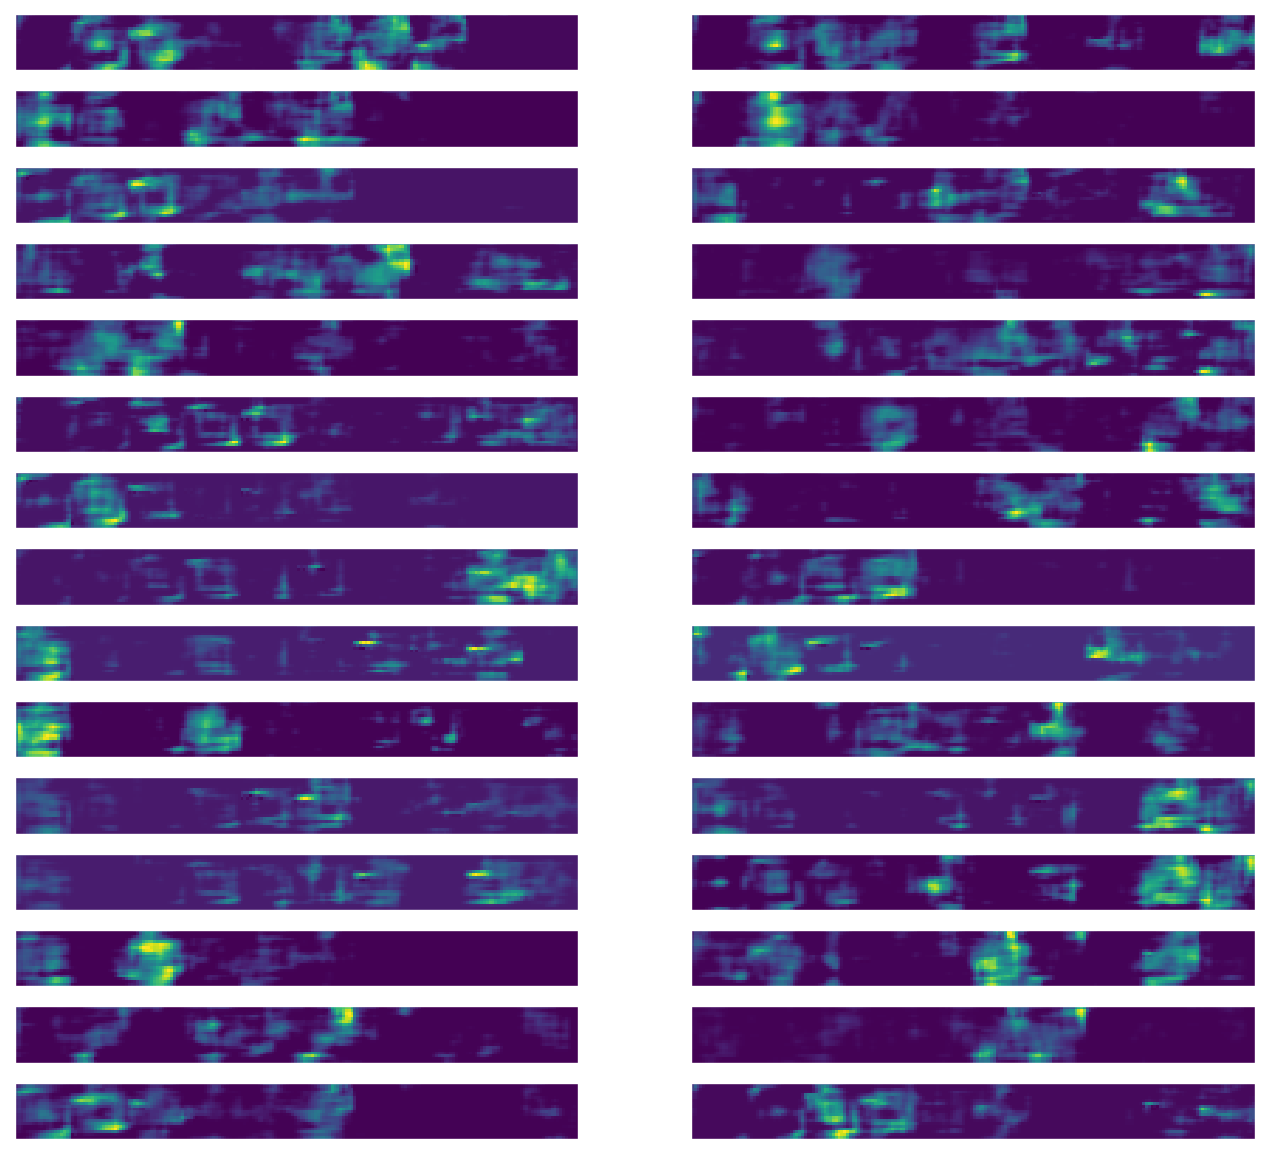

In [12]:
# generate images from the latent space
def generate_images_latent(decoder, n_generation, feature_range):
    # randomly sample the latent space
    latent = []
    for dim in range(latent_dim):
        if len(np.array(feature_range).shape) == 1:
            # only one range provided; used it for all dimensions
            latent.append(np.random.uniform(feature_range[0], feature_range[1], 
                                            n_generation))
        else:
            # range provided for each dimension
            latent.append(np.random.uniform(feature_range[dim][0], feature_range[dim][1], 
                                            n_generation))
    latent = np.array(latent).T
    
    # decode images
    decodings = decoder.predict(latent)
    
    # plot generated images
    fig, axes = plt.subplots(n_generation // 2, 2, figsize=(16, n_generation / 2), dpi=100)
    for ax, image in zip(axes.flatten(), decodings):
        ax.matshow(np.squeeze(image))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()  

# generate random images sampled between [-1, 1]
generate_images_latent(decoder_BVAE, n_generation=30, feature_range=[-1, 1])

---

## Exercises:

1. Tune `latent_dim` and `beta` (and use more epochs) to improve the quality of image generation.
2. Implement a conditional VAE for this INS dataset.